In [6]:
# install packages

!pip install pillow torch torchvision


In [7]:
import torch

import os
import shutil

import cv2

import pandas as pd

from PIL import Image

import yaml
from pathlib import Path # is to handle path

In [8]:
# Set paths
images_dir = "/content/drive/MyDrive/NumberPlate_Datset_with_annotation/images/images"
labels_dir = "/content/drive/MyDrive/NumberPlate_Datset_with_annotation/yolo_labels"

# Preprocessing

In [ ]:
#  Image resizing

# === Seting output folder paths ===

resized_img_dir = "/content/drive/MyDrive/NumberPlate_Datset_with_annotation/resized_images"
resized_lab_dir = "/content/drive/MyDrive/NumberPlate_Datset_with_annotation/resized_labels"

# === Create output folders if they don't exist ===
os.makedirs(resized_img_dir, exist_ok=True)
os.makedirs(resized_lab_dir, exist_ok=True)

# === output image size ===
IMG_SIZE = 640

# === Loop through all images ===
for filename in os.listdir(images_dir):
    if filename.endswith(('.jpg', '.png', '.jpeg')):
        img_path = os.path.join(images_dir, filename)
        label_path = os.path.join(labels_dir, os.path.splitext(filename)[0] + '.txt')

        # Read image
        img = cv2.imread(img_path)
        if img is None:
            print(f"Skipping {filename} — unable to read image.")
            continue

        orig_h, orig_w = img.shape[:2]

        # Resize image to 640x640
        resized_img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        cv2.imwrite(os.path.join(resized_img_dir, filename), resized_img)

        # If label exists, resize coordinates
        if os.path.exists(label_path):
            with open(label_path, "r") as f:
                lines = f.readlines()

            new_lines = []
            for line in lines:
                parts = line.strip().split()
                if len(parts) != 5:
                    continue

                cls, x, y, w, h = map(float, parts)

                # YOLO annotations are normalized (0–1)
                # So we only need to keep the same values — no pixel scaling
                # But if the original labels are in pixels, uncomment below:

                # x /= orig_w
                # y /= orig_h
                # w /= orig_w
                # h /= orig_h

                # Write back normalized labels (same format)
                new_lines.append(f"{int(cls)} {x:.6f} {y:.6f} {w:.6f} {h:.6f}\n")

            with open(os.path.join(resized_lab_dir, os.path.splitext(filename)[0] + '.txt'), "w") as f:
                f.writelines(new_lines)


In [ ]:
# Augmentation # pre process

import os
import cv2
import albumentations as A


# ----  Custom Transforms ---- #
def to_gray(img, **params):
    g = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return cv2.cvtColor(g, cv2.COLOR_GRAY2BGR)

def bilateral(img, **params):
    return cv2.bilateralFilter(img, 9, 75, 75)

# ---- Augmentation ---- #
transform = A.Compose(
    [
        A.RandomBrightnessContrast(p=0.3),
        A.GaussNoise(p=0.1),
        A.Rotate(limit=10, p=0.3),
        A.Lambda(image=to_gray, p=0.3),
        A.Lambda(image=bilateral, p=0.3),
    ],
    bbox_params=A.BboxParams(format="yolo", label_fields=["labels"])
)

# ---- Paths ---- #
img_dir = "/content/drive/MyDrive/NumberPlate_Datset_with_annotation/resized_images"
lab_dir = "/content/drive/MyDrive/NumberPlate_Datset_with_annotation/resized_labels"

out_img = "/content/drive/MyDrive/NumberPlate_Datset_with_annotation/augmented/images"
out_lab = "/content/drive/MyDrive/NumberPlate_Datset_with_annotation/augmented/labels"

os.makedirs(out_img, exist_ok=True)
os.makedirs(out_lab, exist_ok=True)

# ---- Loop ---- #
for file in os.listdir(img_dir):

    if not file.endswith((".jpg", ".png")):
        continue

    img = cv2.imread(os.path.join(img_dir, file))
    if img is None:
        continue

    # load labels
    label_file = file.rsplit(".", 1)[0] + ".txt"
    with open(os.path.join(lab_dir, label_file)) as f:
        lines = [l.strip().split() for l in f.readlines()]
        labels = [int(l[0]) for l in lines]
        boxes = [[float(x) for x in l[1:]] for l in lines]

    # augment
    t = transform(image=img, bboxes=boxes, labels=labels)

    # save image
    cv2.imwrite(os.path.join(out_img, file), t["image"])

    # save label
    with open(os.path.join(out_lab, label_file), "w") as f:
        for lbl, (x, y, w, h) in zip(t["labels"], t["bboxes"]):
            f.write(f"{lbl} {x:.6f} {y:.6f} {w:.6f} {h:.6f}\n")

print("augmentation done!")


augmentation done!


In [ ]:
# data split

import os
import shutil
import random

# --- PATHS ---
images_dir = "/content/drive/MyDrive/NumberPlate_Datset_with_annotation/augmented/images"
labels_dir = "/content/drive/MyDrive/NumberPlate_Datset_with_annotation/augmented/labels"

output_dir = "/content/drive/MyDrive/NumberPlate_Datset_with_annotation/split_dataset"
train_img = os.path.join(output_dir, "train/images")
train_lab = os.path.join(output_dir, "train/labels")

val_img = os.path.join(output_dir, "val/images")
val_lab = os.path.join(output_dir, "val/labels")

test_img = os.path.join(output_dir, "test/images")
test_lab = os.path.join(output_dir, "test/labels")

# Create folders
for p in [train_img, train_lab, val_img, val_lab, test_img, test_lab]:
    os.makedirs(p, exist_ok=True)

# --- LIST ALL IMAGES ---
images = [f for f in os.listdir(images_dir) if f.endswith((".jpg", ".png"))]

random.shuffle(images)

# Split sizes
total = len(images)
train_size = int(total * 0.8)
val_size = int(total * 0.1)

train_files = images[:train_size]
val_files   = images[train_size: train_size + val_size]
test_files  = images[train_size + val_size:]

def copy_pair(img_list, out_img_dir, out_lab_dir):
    for img_name in img_list:
        name = os.path.splitext(img_name)[0]
        lab_name = name + ".txt"

        # copy image
        shutil.copy(
            os.path.join(images_dir, img_name),
            os.path.join(out_img_dir, img_name)
        )
        # copy label
        shutil.copy(
            os.path.join(labels_dir, lab_name),
            os.path.join(out_lab_dir, lab_name)
        )

# Copy to folders
copy_pair(train_files, train_img, train_lab)
copy_pair(val_files, val_img, val_lab)
copy_pair(test_files, test_img, test_lab)

print("✔ Dataset Split Completed!")
print(f"Train: {len(train_files)} images")
print(f"Val:   {len(val_files)} images")
print(f"Test:  {len(test_files)} images")


✔ Dataset Split Completed!
Train: 434 images
Val:   54 images
Test:  55 images


# Model Training:

In [9]:
!pip install ultralytics

from ultralytics import YOLO

model = YOLO("yolov8s.pt")  # auto-downloads

In [10]:
# data handling

os.makedirs("f_project/split_dataset")

In [12]:
# moving data from drive to yolo folder

import shutil

dst = "/content/f_project/split_dataset"
output_dir = "/content/drive/MyDrive/NumberPlate_Datset_with_annotation/split_dataset"
shutil.copytree(output_dir, dst, dirs_exist_ok=True)

print("Dataset copied successfully!")


Dataset copied successfully!


In [22]:
# setup parameter - only for yolo
from pathlib import Path

yolo8_yaml = {
    "path": "/content/f_project/split_dataset",
    "train": "/content/f_project/split_dataset/train/images",
    "val": "/content/f_project/split_dataset/val/images",
    "test": "/content/f_project/split_dataset/test/images",
    "names": {
        0: "plate"
    }
}

In [23]:
# yamal file
import yaml

with open("/content/f_project/split_dataset/data.yaml", "w") as f:
  yaml.dump(yolo8_yaml, f, sort_keys=False)

In [25]:
# Training
from ultralytics import YOLO

model.train(data="/content/f_project/split_dataset/data.yaml", epochs=40, imgsz=320, batch=16)

Ultralytics 8.3.228 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/f_project/split_dataset/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=40, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=320, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train7, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plo

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f896e053140>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

In [29]:
!yolo detect predict model=/content/runs/detect/train7/weights/best.pt source=/content/f_project/split_dataset/test/images/20230620_160530ll.jpg conf=0.1 imgsz=500

Ultralytics 8.3.228 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
image 1/1 /content/f_project/split_dataset/test/images/20230620_160530ll.jpg: 512x512 1 plate, 13.2ms
Speed: 2.8ms preprocess, 13.2ms inference, 2.8ms postprocess per image at shape (1, 3, 512, 512)
Results saved to /content/runs/detect/predict2
💡 Learn more at https://docs.ultralytics.com/modes/predict


In [36]:
!yolo detect predict model=/content/runs/detect/train7/weights/best.pt source=/content/f_project/split_dataset/test/images/Cars258.png conf=0.1 imgsz=500

Ultralytics 8.3.228 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
image 1/1 /content/f_project/split_dataset/test/images/Cars258.png: 512x512 1 plate, 10.8ms
Speed: 2.3ms preprocess, 10.8ms inference, 1.9ms postprocess per image at shape (1, 3, 512, 512)
Results saved to /content/runs/detect/predict7
💡 Learn more at https://docs.ultralytics.com/modes/predict


In [33]:
!yolo detect predict model=/content/runs/detect/train7/weights/best.pt source=/content/f_project/split_dataset/test/images/20230614_150948ll.jpg conf=0.1 imgsz=500

Ultralytics 8.3.228 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
image 1/1 /content/f_project/split_dataset/test/images/20230614_150948ll.jpg: 512x512 3 plates, 14.0ms
Speed: 4.4ms preprocess, 14.0ms inference, 2.7ms postprocess per image at shape (1, 3, 512, 512)
Results saved to /content/runs/detect/predict6
💡 Learn more at https://docs.ultralytics.com/modes/predict


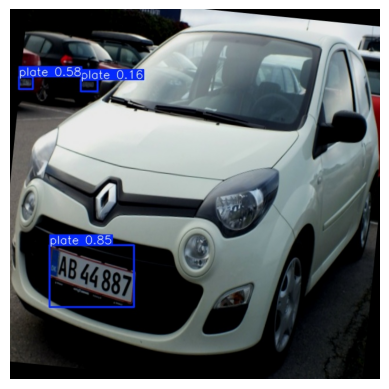

In [35]:
import cv2
import matplotlib.pyplot as plt

img_path = "/content/runs/detect/predict5/Cars389.jpg"

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.axis("off")
plt.show()

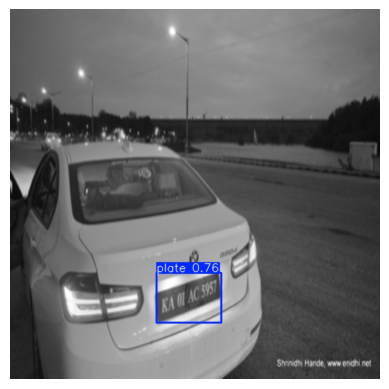

In [37]:
import cv2
import matplotlib.pyplot as plt

img_path = "/content/runs/detect/predict7/Cars258.jpg"

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.axis("off")
plt.show()

# Post Processing

In [38]:
!pip install easyocr


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 47.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.7/180.7 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 963.8/963.8 kB 44.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.6/300.6 kB 22.6 MB/s eta 0:00:00


In [58]:
!sudo apt install tesseract-ocr
!pip install pytesseract

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.



0: 320x320 1 plate, 13.2ms
Speed: 1.2ms preprocess, 13.2ms inference, 2.0ms postprocess per image at shape (1, 3, 320, 320)
Detected Plate Crop:


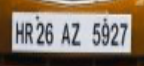

OCR Raw: H26AZ58279
OCR Cleaned: H26AZ58279


'H26AZ58279'

In [67]:
import cv2
import numpy as np
import pytesseract
from ultralytics import YOLO
from google.colab.patches import cv2_imshow
import re

# -------------------------------
# WINDOWS USERS ONLY (Uncomment)
# pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"
# -------------------------------

# Load YOLO model
model = YOLO("/content/runs/detect/train7/weights/best.pt")

# Tesseract config
tess_config = r"--oem 3 --psm 7 -c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789"


def clean_plate(text):
    """Clean text into proper number plate format."""
    text = text.upper().replace(" ", "")
    match = re.findall(r"[A-Z]{2}[0-9]{1,2}[A-Z]{1,2}[0-9]{3,4}", text)
    return match[0] if match else text


def detect_and_ocr(image_path):
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    results = model.predict(img_rgb, conf=0.25)

    # ---------------------------------
    # USE FIRST DETECTION ONLY (your request)
    # ---------------------------------
    boxes = results[0].boxes.xyxy.cpu().numpy()

    if len(boxes) == 0:
        print("No plate detected")
        return

    # FIRST detection (YOLO sorted by highest confidence)
    x1, y1, x2, y2 = map(int, boxes[0][:4])

    # Padding
    pad = 10
    H, W = img_rgb.shape[:2]

    x1p = max(0, x1 - pad)
    y1p = max(0, y1 - pad)
    x2p = min(W, x2 + pad)
    y2p = min(H, y2 + pad)

    # Crop with padding
    crop = img_rgb[y1p:y2p, x1p:x2p]

    print("Detected Plate Crop:")
    cv2_imshow(crop)

    # OCR input (grayscale only)
    gray = cv2.cvtColor(crop, cv2.COLOR_RGB2GRAY)

    # OCR
    raw_text = pytesseract.image_to_string(gray, config=tess_config)
    raw_text = raw_text.strip().replace("\n", "")

    cleaned = clean_plate(raw_text)

    print("OCR Raw:", raw_text)
    print("OCR Cleaned:", cleaned)

    return cleaned


# Run the OCR
detect_and_ocr("/content/f_project/split_dataset/test/images/Cars387.png")





# Perfomance Metrics

In [68]:
# Mean Average Precision (mAP)

from ultralytics import YOLO

model = YOLO("/content/runs/detect/train7/weights/best.pt")

model.val(data="/content/f_project/split_dataset/data.yaml", imgsz=320)

Ultralytics 8.3.228 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2479.7±223.9 MB/s, size: 510.1 KB)
val: Scanning /content/f_project/split_dataset/val/labels.cache... 54 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 54/54 95.6Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 4/4 2.2it/s 1.9s
                   all         54         78      0.799      0.718      0.743      0.382
Speed: 2.8ms preprocess, 11.4ms inference, 0.0ms loss, 3.2ms postprocess per image
Results saved to /content/runs/detect/val


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f89d7e6acf0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

In [86]:
# IOU

import cv2

# 1. RUN YOLO AND GET PRED BOX

results = model(img_rgb)

# take highest confidence box
pred = results[0].boxes.xyxy[0].cpu().numpy()
pred_box = [int(pred[0]), int(pred[1]), int(pred[2]), int(pred[3])]
print("Predicted Box:", pred_box)

# 2. READ GROUND TRUTH BOX
label_path = "/content/f_project/split_dataset/test/labels/Cars389.txt"

with open(label_path, "r") as f:
    cls, xc, yc, w, h = map(float, f.readline().split())

H, W = img_rgb.shape[:2]

# Convert YOLO → XYXY
x1 = int((xc - w/2) * W)
y1 = int((yc - h/2) * H)
x2 = int((xc + w/2) * W)
y2 = int((yc + h/2) * H)
gt_box = [x1, y1, x2, y2]
print("Ground Truth Box:", gt_box)

# 3. COMPUTE SIMPLE IoU
def compute_iou(box1, box2):
    xa = max(box1[0], box2[0])
    ya = max(box1[1], box2[1])
    xb = min(box1[2], box2[2])
    yb = min(box1[3], box2[3])

    inter_area = max(0, xb - xa) * max(0, yb - ya)

    box1_area = (box1[2]-box1[0]) * (box1[3]-box1[1])
    box2_area = (box2[2]-box2[0]) * (box2[3]-box2[1])

    union = box1_area + box2_area - inter_area

    return inter_area / union if union > 0 else 0

iou = compute_iou(pred_box, gt_box)
print("IoU:", iou)



0: 320x320 2 plates, 13.1ms
Speed: 3.3ms preprocess, 13.1ms inference, 2.3ms postprocess per image at shape (1, 3, 320, 320)
Predicted Box: [67, 397, 215, 517]
Ground Truth Box: [62, 409, 225, 516]
IoU: 0.8177640072295378


In [88]:
import os
import cv2
import numpy as np
from ultralytics import YOLO


# CONFIG
WEIGHTS = "/content/runs/detect/train7/weights/best.pt"
images_dir = "/content/f_project/split_dataset/test/images"
labels_dir = "/content/f_project/split_dataset/test/labels"
iou_threshold = 0.5

# HELPER: IoU
def iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    inter = max(0, xB - xA) * max(0, yB - yA)
    areaA = max(0, (boxA[2] - boxA[0])) * max(0, (boxA[3] - boxA[1]))
    areaB = max(0, (boxB[2] - boxB[0])) * max(0, (boxB[3] - boxB[1]))
    union = areaA + areaB - inter

    return inter / union if union > 0 else 0

# LOAD YOLOv8 MODEL

model = YOLO(WEIGHTS)

TP = FP = FN = 0

# LOOP THROUGH TEST IMAGES
for img_name in os.listdir(images_dir):

    if not img_name.endswith((".png", ".jpg", ".jpeg")):
        continue

    img_path = os.path.join(images_dir, img_name)
    label_path = os.path.join(labels_dir, img_name.rsplit(".", 1)[0] + ".txt")

    img = cv2.imread(img_path)
    if img is None:
        print("Cannot read:", img_path)
        continue

    H, W = img.shape[:2]

    # LOAD GROUND TRUTH

    try:
        with open(label_path, "r") as f:
            cls, xc, yc, w, h = map(float, f.readline().split())
    except:
        print("No label found for:", img_name)
        continue

    gt_box = [
        int((xc - w/2) * W),
        int((yc - h/2) * H),
        int((xc + w/2) * W),
        int((yc + h/2) * H)
    ]


    # YOLOv8 PREDICTION

    results = model.predict(img, conf=0.25, verbose=False)
    boxes = results[0].boxes.xyxy.cpu().numpy()

    if len(boxes) == 0:
        FN += 1   # missed completely
        continue

    # FIRST prediction (highest confidence)
    p = boxes[0]
    pred_box = [int(p[0]), int(p[1]), int(p[2]), int(p[3])]

    # IoU CHECK

    i = iou(pred_box, gt_box)

    if i >= iou_threshold:
        TP += 1
    else:
        FP += 1
        FN += 1


# FINAL METRICS

FPR = FP / (TP + FP) if (TP + FP) > 0 else 0
FNR = FN / (TP + FN) if (TP + FN) > 0 else 0

print("\n----- RESULTS -----")
print("TP:", TP)
print("FP:", FP)
print("FN:", FN)
print("False Positive Rate:", round(FPR, 3))
print("False Negative Rate:", round(FNR, 3))



----- RESULTS -----
TP: 46
FP: 8
FN: 9
False Positive Rate: 0.148
False Negative Rate: 0.164
